# LeNet-5

In [1]:
# 라이브러리 불러오기
%load_ext tensorboard

import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout

In [4]:
num_classes=2
class LeNet(Sequential):
    def __init__(self,input_shape,nb_classes):
        super().__init__()
        
        self.add(Conv2D(6,kernel_size=(5,5),strides=(1,1),activation='relu',input_shape=input_shape,padding='same')) # 1
        self.add(AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='valid')) # 2
        self.add(Conv2D(16,kernel_size=(5,5),strides=(1,1),activation='relu',padding='valid'))
        self.add(AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))
        self.add(Flatten())
        self.add(Dense(120,activation='relu'))
        self.add(Dense(84,activation='relu'))
        self.add(Dense(nb_classes,activation='softmax'))
        
        self.compile(optimizer='adam',
                    loss=categorical_crossentropy,
                    metrics=['accuracy'])

- 전처리없이 바로 신경망을 구축한 과정임, 입력값은 이미지이며 출력값은 클래스의 확률 벡터가 됨

- 1 Conv2D
    - 6(첫번째 파라미터) - 필터 개수
    - kernel_size=(5,5) : 두번째 파라미터, 커널의 행과 열 의미
    - strides=(1,1) : 필터를 적용하는 간격
    - activation='relu' : 활성화 함수를 설정, 여기서는 relu 사용
    - input_shape=input_shape : 입력 이미지 형태 정의 (행,열,채널 개수)로 정의하며 흑백 영상은 채널을 1로 설정하고 컬러는 채널을 3으로 설정
    - padding : padding의 값이 same인 것은 출력 이미지 크기와 입력 이미지 크기가 동일하다는 것
- 2 AveragePooling2D
    - pool_size=연산 범위를 의미하는 것, 해당 범위 내의 평균을 가져옴
    - strides :  필터가 계산 과정에서 한 스텝마다 이동하는 크기 의미, 스트라이드가 미리 설정되지 않으면, pool_size와 동일하게 설정
    - padding : 연산 전에 주변에 빈 값을 넣어 이미지 크기를 유지할지에 대해 설정
        - valid : 비활성화
        - same : 빈 값을 넣어 입력과 출력의 크기가 같도록 설정

In [5]:
# LeNet-5 모델 생성
model=LeNet((100,100,3),num_classes)
model.summary()

Model: "le_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 6)       456       
                                                                 
 average_pooling2d_1 (Averag  (None, 50, 50, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 46, 46, 16)        2416      
                                                                 
 average_pooling2d_2 (Averag  (None, 23, 23, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 8464)              0         
                                                                 
 dense (Dense)               (None, 120)               101

- 전달되는 입력값은 (100,100,3) 형태이고, 출력은 개와 고양이를 표현하는 값 2가 나옴

In [6]:
# 파라미터 초기화 및 데이터 호출
EPOCHS=100
BATCH_SIZE=32
image_height=100
image_width=100
train_dir='C:/Users/이신행/OneDrive/바탕 화면/딥러닝텐서플로교과서_예제파일/chap5/data/catanddog/train'
valid_dir='C:/Users/이신행/OneDrive/바탕 화면/딥러닝텐서플로교과서_예제파일/chap5/data/catanddog/validation'

In [8]:
# 이미지 데이터 증가
train=ImageDataGenerator(rescale=1./255,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.1,
                        zoom_range=0.1)

train_generator=train.flow_from_directory(train_dir,
                                         target_size=(image_height,image_width),
                                         color_mode='rgb',
                                         batch_size=BATCH_SIZE,
                                         seed=1,
                                         shuffle=True,
                                         class_mode='categorical')

valid=ImageDataGenerator(rescale=1/255)
valid_generator = valid.flow_from_directory(valid_dir,
                                                    target_size=(image_height, image_width),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=7,
                                                    shuffle=True,
                                                    class_mode="categorical"
                                                    )

train_num=train_generator.samples
valid_num=valid_generator.samples

Found 385 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [10]:
# 텐서보드에서 모델 훈련과정 살펴보기
log_dir='C:/Users/이신행/OneDrive/바탕 화면/딥러닝텐서플로교과서_예제파일/chap6/img/log6-1'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0) # 1

- 케라스에서 제공하는 callback은 에포크의 시작과 끝처럼 이벤트가 발생할 때 호출되며, 다음 기능을 위해 사용
    - 정확도가 특정 임계치를 초과할때 저장
    - 이메일을 보내거나 학습을 종료할때 알림보내기
   
    - log_dir : 로그 파일이 기록될 위치
    - histograom_freq : 매 에포크마다 출력을 히스토그램으로 기록, 값이 0이라면 히스토그램이 기록되지 않으며, 기본값은 0
    - profile_batch : 훈련이 진해되는 시간 및 시스템 자원 등에 대한 사용을 관리하는 것, 기본적으로 두번재 배치부터 계산을 진행, 이 기능을 비활성화하려면 profile_batch=0으로 설정

In [11]:
model.fit(train_generator,
         epochs=EPOCHS,
         steps_per_epoch=train_num//BATCH_SIZE,
         validation_data=valid_generator,
          validation_steps=valid_num//BATCH_SIZE,
          callbacks=[tensorboard_callback],
          verbose=1) # 2

Epoch 1/100
12/12 [==============================] - 3s 200ms/step - loss: 0.7566 - accuracy: 0.4618 - val_loss: 0.6961 - val_accuracy: 0.4896
Epoch 2/100
12/12 [==============================] - 2s 179ms/step - loss: 0.6934 - accuracy: 0.4929 - val_loss: 0.6920 - val_accuracy: 0.4896
Epoch 3/100
12/12 [==============================] - 2s 169ms/step - loss: 0.6942 - accuracy: 0.5212 - val_loss: 0.6948 - val_accuracy: 0.4896
Epoch 4/100
12/12 [==============================] - 2s 189ms/step - loss: 0.6908 - accuracy: 0.5573 - val_loss: 0.6923 - val_accuracy: 0.5312
Epoch 5/100
12/12 [==============================] - 2s 176ms/step - loss: 0.6874 - accuracy: 0.5581 - val_loss: 0.6924 - val_accuracy: 0.4896
Epoch 6/100
12/12 [==============================] - 2s 179ms/step - loss: 0.7080 - accuracy: 0.5439 - val_loss: 0.7150 - val_accuracy: 0.4792
Epoch 7/100
12/12 [==============================] - 2s 191ms/step - loss: 0.6969 - accuracy: 0.5326 - val_loss: 0.6893 - val_accuracy: 0.4896

Epoch 58/100
12/12 [==============================] - 2s 190ms/step - loss: 0.4808 - accuracy: 0.7450 - val_loss: 0.9194 - val_accuracy: 0.5208
Epoch 59/100
12/12 [==============================] - 3s 213ms/step - loss: 0.4719 - accuracy: 0.7422 - val_loss: 1.0342 - val_accuracy: 0.5833
Epoch 60/100
12/12 [==============================] - 2s 188ms/step - loss: 0.4816 - accuracy: 0.7819 - val_loss: 0.9271 - val_accuracy: 0.5104
Epoch 61/100
12/12 [==============================] - 2s 204ms/step - loss: 0.4872 - accuracy: 0.7564 - val_loss: 0.9410 - val_accuracy: 0.5312
Epoch 62/100
12/12 [==============================] - 2s 188ms/step - loss: 0.4487 - accuracy: 0.7875 - val_loss: 1.0153 - val_accuracy: 0.5417
Epoch 63/100
12/12 [==============================] - 2s 209ms/step - loss: 0.5115 - accuracy: 0.7280 - val_loss: 0.8651 - val_accuracy: 0.5417
Epoch 64/100
12/12 [==============================] - 2s 195ms/step - loss: 0.5136 - accuracy: 0.7195 - val_loss: 0.8431 - val_accuracy:

- 2 : 모델을 학습시킬 때 fit() 메서드를 사용하는데, 파라미터에 따라 학습과정 및 결과가 달라짐
    - train_generator(첫번째 파라미터) : 입력 데이터
    - epochs :  학습 횟수, 에포크 횟수가 증가하면, 훈련 데이터셋의 정확도는 증가하지만, 검증 데이터셋의 정확도는 오히려 감소할 수 있기 때문에, 적절한 설명이 필요
    - steps_per_epoch : 한 에포크에서 사용한 스텝(모델이 가진 파라미터(가중치)를 1회 업데이트 하는것)의 개수 지정
    - validation_data : 성능을 모니터링하는데 사용하는 데이터셋 설정, 여기에서는 검증 데이터셋을 사용하여 간편하게 성능 모니터링
    - validation_steps : 한 에포크가 종료될 때 사용되는 검증 스텝 개수 지정
    - callbacks=[tensorboard_callback] : 텐서보드라는 콜백함수를 생성한 뒤에 fit() 메서드의 파라미터로 넣어줌
    - verbose : 훈련의 진행 과정을 보여줌, 0이면 아무것도 출력하지 않고, 1이면 훈련의 진행도를 표시하는 진행막대를 보여줌, 2면 미니 배치보다 훈련 정보를 출력

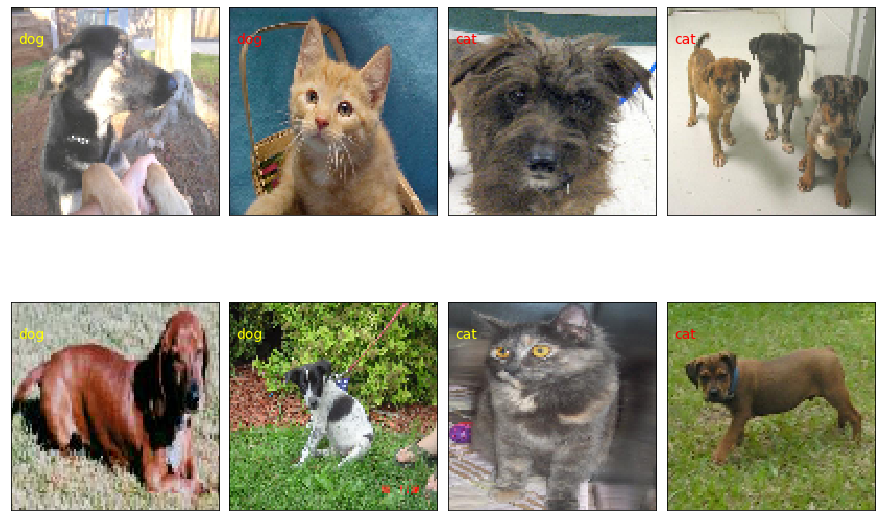

In [14]:
# 이미지 데이터셋 분류에 따른 예측
class_names=['cat','dog']
validation, label_batch=next(iter(valid_generator))
prediction_values=model.predict(validation)
prediction_values=np.argmax(prediction_values,axis=1)

fig=plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)

for i in range(8):
    ax=fig.add_subplot(2,4,i+1,xticks=[],yticks=[])
    ax.imshow(validation[i,:],cmap=plt.cm.gray_r,interpolation='nearest')
    
    if prediction_values[i] == np.argmax(label_batch[i]):
        ax.text(3,17,class_names[prediction_values[i]],color='yellow',fontsize=14)
    else:
        ax.text(3,17,class_names[prediction_values[i]],color='red',fontsize=14)

# AlexNet

In [15]:
# 라이브러리 불러오기
%load_ext tensorboard

import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [18]:
# 모델 생성
num_classes = 2
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal')) # 1
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) # 2

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

- 1 : 가중치 초기화 방법으로 kernel_initializer 파라미터 사용
- 2 : data_format은 입력에 대한 형식을 지정할 때 사용
    - 입력 형식을 설정하는 파라미터로 channels_last와 channels_first가 있음 기본값은 channels_last임 이는 입력 데이터 텐서의 형식이 (배치 크기, 높이, 너비, 채널개수)가 되며, channels_first를 사용시 입력 데이터 텐서의 형식이 (배치 크기, 채널개수, 높이, 너비)가 됨

In [19]:
# 모델 생성
model=AlexNet((100,100,3),num_classes)
model.summary()

Model: "alex_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 23, 23, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 96)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 256)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 5, 384)         885120    
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 5, 384)         132

- AlexNet의 경우는 파라미터를 6000만개 사용하는데, 이때 충분한 데이터가 없으면 과적합 발생

In [20]:
# 데이터 호출 및 데이터 전처리(증가)
EPOCHS=100
BATCH_SIZE=32
image_height=100
image_width=100
train_dir='C:/Users/이신행/OneDrive/바탕 화면/딥러닝텐서플로교과서_예제파일/chap5/data/catanddog/train'
valid_dir='C:/Users/이신행/OneDrive/바탕 화면/딥러닝텐서플로교과서_예제파일/chap5/data/catanddog/validation'

trian=ImageDataGenerator(rescale=1./255,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.1,
                        zoom_range=0.1)

train_generator=train.flow_from_directory(train_dir,
                                         target_size=(image_height,image_width),
                                         color_mode='rgb',
                                         batch_size=BATCH_SIZE,
                                         seed=1,
                                         shuffle=True,
                                         class_mode='categorical')

valid=ImageDataGenerator(rescale=1/255)
valid_generator=valid.flow_from_directory(valid_dir,
                                         target_size=(image_height,image_width),
                                         color_mode='rgb',
                                         batch_size=BATCH_SIZE,
                                         seed=7,
                                         shuffle=True,
                                         class_mode='categorical')

train_num=train_generator.samples
valid_num=valid_generator.samples

Found 385 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [21]:
# 텐서보드에서 설정 및 모델 훈련
log_dir='C:/Users/이신행/OneDrive/바탕 화면/딥러닝텐서플로교과서_예제파일/chap6/img/log6-2'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

model.fit(train_generator,
         epochs=EPOCHS,
         steps_per_epoch=train_num//BATCH_SIZE,
         validation_data=valid_generator,
         validation_steps=valid_num//BATCH_SIZE,
         callbacks=[tensorboard_callback],
         verbose=1)

Epoch 1/100
12/12 [==============================] - 16s 1s/step - loss: 9.3832 - accuracy: 0.5127 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/100
12/12 [==============================] - 12s 1s/step - loss: 0.6961 - accuracy: 0.4646 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 3/100
12/12 [==============================] - 9s 788ms/step - loss: 0.6974 - accuracy: 0.4731 - val_loss: 0.6931 - val_accuracy: 0.5104
Epoch 4/100
12/12 [==============================] - 10s 817ms/step - loss: 0.6931 - accuracy: 0.5184 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/100
12/12 [==============================] - 10s 852ms/step - loss: 0.6930 - accuracy: 0.5354 - val_loss: 0.6939 - val_accuracy: 0.4896
Epoch 6/100
12/12 [==============================] - 8s 702ms/step - loss: 0.6924 - accuracy: 0.5184 - val_loss: 0.6930 - val_accuracy: 0.5104
Epoch 7/100
12/12 [==============================] - 10s 822ms/step - loss: 0.6932 - accuracy: 0.5184 - val_loss: 0.6935 - val_accuracy: 0.4896


Epoch 58/100
12/12 [==============================] - 9s 773ms/step - loss: 0.6924 - accuracy: 0.5241 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 59/100
12/12 [==============================] - 9s 773ms/step - loss: 0.6913 - accuracy: 0.5326 - val_loss: 0.6931 - val_accuracy: 0.5104
Epoch 60/100
12/12 [==============================] - 13s 1s/step - loss: 0.6921 - accuracy: 0.5212 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 61/100
12/12 [==============================] - 10s 801ms/step - loss: 0.6914 - accuracy: 0.5286 - val_loss: 0.6962 - val_accuracy: 0.4896
Epoch 62/100
12/12 [==============================] - 9s 776ms/step - loss: 0.6908 - accuracy: 0.5354 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 63/100
12/12 [==============================] - 12s 979ms/step - loss: 0.6904 - accuracy: 0.5382 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 64/100
12/12 [==============================] - 10s 878ms/step - loss: 0.6918 - accuracy: 0.5269 - val_loss: 0.6934 - val_accuracy

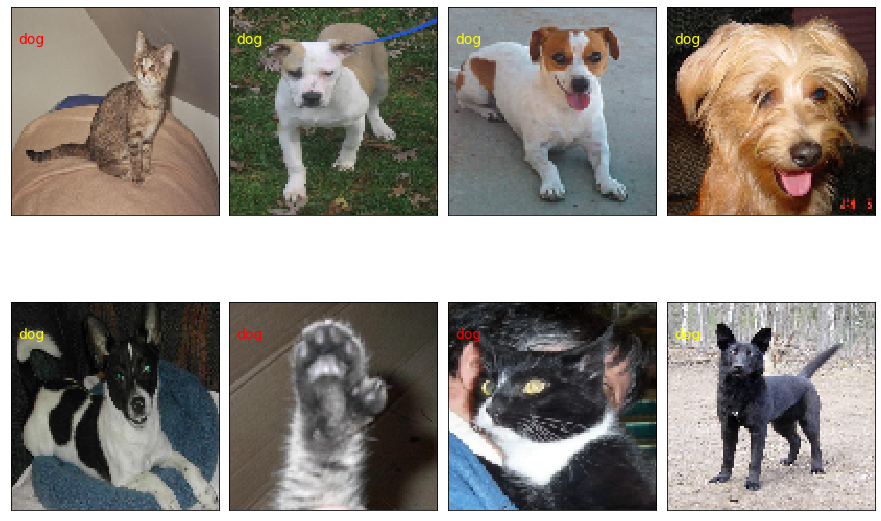

In [22]:
# 분류에 대한 예측
class_names=['cat','dog']
validation,label_batch=next(iter(valid_generator))
prediction_values=model.predict(validation)
prediction_values=np.argmax(prediction_values,axis=1)

fig=plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)

for i in range(8):
    ax=fig.add_subplot(2,4,i+1,xticks=[],yticks=[])
    ax.imshow(validation[i,:],cmap=plt.cm.gray_r,interpolation='nearest')
    
    if prediction_values[i]==np.argmax(label_batch[i]):
        ax.text(3,17,class_names[prediction_values[i]],color='yellow',fontsize=14)
    else:
        ax.text(3,17,class_names[prediction_values[i]],color='red',fontsize=14)

# VGGNet

In [23]:
!pip install opencv-python

In [24]:
# 필요한 라이브러리 호출
%load_ext tensorboard

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 # 얼굴 인식, 물체 식별, 이미지 결함 등 작업이 가능한 오픈 소스 라이브러리

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [41]:
# VGG19 네트워크 생성
class VGG19(Sequential):
    def __init__(self, input_shape):
        super().__init__()

        self.add(Conv2D(64, kernel_size=(3,3), padding= 'same',
                        activation= 'relu', input_shape= input_shape))
        self.add(Conv2D(64, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(128, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(128, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.5))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.5))
        self.add(Dense(1000, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.003),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [42]:
model=VGG19(input_shape=(224,224,3))
model.summary()

Model: "vgg19_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_27 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                       

In [43]:
# 사전 훈련된 VGG19 가중치 내려받기
model.load_weights('C:/Users/이신행/OneDrive/바탕 화면/딥러닝텐서플로교과서_예제파일/chap6/data/vgg19_weights_tf_dim_ordering_tf_kernels.h5')

In [44]:
# 클래스 정의
classes= {282: 'cat',
 681: 'notebook, notebook computer',
 970: 'alp'} # 검증용으로 사용될 클랫느ㅡㄴ 세개만 적용, 전체 이미지에 대한 클래서는 classes.txt 참고

In [46]:
# 이미지 호출 및 예측
image1=cv2.imread('laptop.jpg')
#image1=cv2.imread('C:/Users/이신행/OneDrive/바탕 화면/딥러닝텐서플로교과서_예제파일/chap6/data/starrynight.jpeg')
#image1=cv2.imread('C:/Users/이신행/OneDrive/바탕 화면/딥러닝텐서플로교과서_예제파일/chap6/data/cat.jpg')
image1 = cv2.resize(image1, (224, 224))
plt.figure()
plt.imshow(image1)
image1 = image1[np.newaxis, :] # 차원 확장 : 행추가
predicted_value = model.predict(image1)
predicted_value = np.argmax(predicted_value)
plt.title(classes[predicted_value[0]]) # 출력에 대한 제목 지정

# ps. 결과가 오류가 나옵니당 추후에 원인 찾아볼게욥

error: OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


# ResNet

In [47]:
# 아이덴티티 블록
def res_identity(x,filters):
    x_skip=x # 레지듀얼 블록을 추가하는데 사용
    f1,f2=filters
    
    x=Conv2D(f1,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_regularizer=12(0.001))(x)
    x=BatchNormalization()(x) # 데이터의 평균을 0으로, 표준편차를 1로 분포시킴
    x=Activation(activations.relu)(x) # 첫번째 블록
    
    x= Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x= BatchNormalization()(x)
    x= Activation(activations.relu)(x) # 두번째 블록
    
    x=Conv2D(f2,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_regularizer=12(0.001))(x)
    x=BatchNormalization()(x) # 세번째 블록
    
    x=Add()([x,x_skip])
    x=Activation(activaitons.relu)(x)
    
    return x 

<>:6: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:14: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:6: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:14: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<ipython-input-47-2edf237b050e>:6: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  x=Conv2D(f1,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_regularizer=12(0.001))(x)
<ipython-input-47-2edf237b050e>:14: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  x=Conv2D(f2,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_regularizer=12(0.001))(x)


In [48]:
# 합성곱 블록
def res_conv(x, s, filters):
    x_skip = x
    f1, f2 = filters

    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
      # when s = 2 then it is like downsizing the feature map
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x) # 첫번째 블록

    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x) # 두번째 블록

    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x) # 세번째 블록

    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip) # 숏컷

    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x